In [1]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

import torch
import torch.nn as nn

c:\Users\fredr\AppData\Local\GitHubDesktop\app-3.4.12\TomoDpDt\tomodpdt\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


In [2]:
import importlib
# From parent directory
import sys
sys.path.append('..')

from OldCode import rotations as R
from OldCode import forward_model as F

In [3]:
RI_RANGE = (1.33, 1.35)
SIZE = 64
SAMPLES = 400

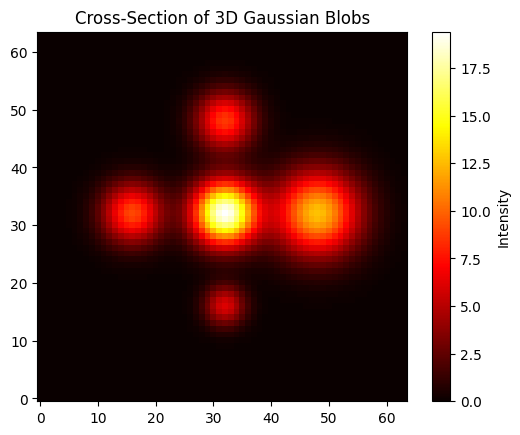

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

grid = np.zeros((SIZE, SIZE, SIZE))  # 3D grid

# Gaussian blob parameters
centers = [(16, 32, 32), (48, 32, 32), (32, 16, 32), 
           (32, 48, 32), (32, 32, 16), (32, 32, 48),
           ]  # Center positions

# Generate blobs
sigma_random = np.random.uniform(2, 6, len(centers))
for i, center in enumerate(centers):
    x, y, z = np.indices((SIZE, SIZE, SIZE))  # 3D coordinates
    blob = np.exp(-((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2) / (2 * sigma_random[i]**2))
    grid += blob  # Add each blob to the grid

# Normalize the grid for visualization
grid /= grid.max()

# Plot a 2D cross-section at z=48
plt.imshow(grid.sum(axis=2), cmap="hot", origin="lower")
plt.colorbar(label="Intensity")
plt.title("Cross-Section of 3D Gaussian Blobs")
plt.show()



In [5]:
#Scale to RI range
grid = grid * (RI_RANGE[1] - RI_RANGE[0]) + RI_RANGE[0]
volume = grid


In [6]:
def setup_optics_torch(nsize, wavelength=532e-9, resolution=100e-9, magnification=1, return_field=True):
    """
    Set up the optical system, prepare simulation parameters, and compute the optical image.

    Args:
        nsize (int): Size of the volume grid.
        wavelength (float): Wavelength of light in meters (default 532 nm).
        resolution (float): Optical resolution in meters (default 100 nm).
        magnification (float): Magnification factor (default 1).
        return_field (bool): Whether to return the optical field (default True).

    Returns:
        dict: A dictionary containing optics object, limits, fields, properties, and computed image.
    """

    # Define the optics
    optics = dt.optics_torch.Brightfield(
        wavelength=wavelength,
        resolution=resolution,
        magnification=magnification,
        output_region=(0, 0, nsize, nsize),
        return_field=return_field
    )

    # Define simulation limits
    limits = torch.tensor([[0, nsize], [0, nsize], [-nsize//2, nsize//2]])

    # Define fields
    padded_nsize = ((nsize + 31) // 32) * 32
    fields = torch.ones((padded_nsize, padded_nsize), dtype=torch.complex64)

    # Extract relevant properties from the optics
    properties = optics.properties()
    filtered_properties = {
        k: v for k, v in properties.items()
        if k in {'padding', 'output_region', 'NA', 'wavelength', 
                 'refractive_index_medium', 'return_field'}
        }   

    return {
        "optics": optics,
        "limits": limits,
        "fields": fields,
        "filtered_properties": filtered_properties,
        }

class imaging_model(nn.Module):
    def __init__(self, optics_setup):
        """
        Initialize the imaging model.

        Args:
            optics_setup (dict): A dictionary containing optics object, limits, fields, properties, and computed image.
        """

        super().__init__()
        self.optics = optics_setup['optics']
        self.limits = optics_setup['limits']
        self.fields = optics_setup['fields']
        self.filtered_properties = optics_setup['filtered_properties']

    def forward(self, object):
        """
        Compute the optical image of an object.

        Args:
            object (torch.Tensor): Object to image.

        Returns:
            torch.Tensor: Optical image of the object.
        """
        # Move evertything to the same device
        #self.limits = self.limits.to(object.device)
        #self.fields = self.fields.to(object.device)
        #or key in self.filtered_properties:
        #   self.filtered_properties[key] = self.filtered_properties[key].to(object.device)
        
        # Move everything to the same device
        self.limits = self.limits.to(object.device)
        self.fields = self.fields.to(object.device)

        return self.optics.get(object, self.limits, self.fields, **self.filtered_properties)


In [7]:
optical_setup_torch = setup_optics_torch(nsize=64, wavelength=532e-9, resolution=100e-9, magnification=1, return_field=True)
imaging_model_torch = imaging_model(optical_setup_torch)
image_torch = imaging_model_torch (torch.tensor(volume))

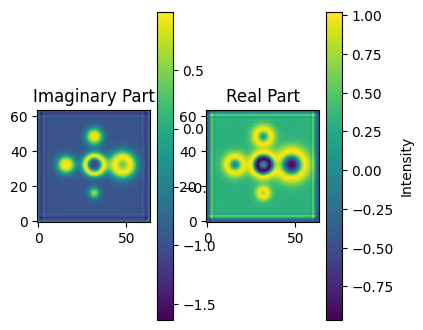

In [8]:
plt.figure(figsize=(4, 4))
plt.subplot(121)
plt.imshow(image_torch.imag, origin="lower")
plt.colorbar(label="Intensity")
plt.title("Imaginary Part")
plt.subplot(122)
plt.imshow(image_torch.real, origin="lower")
plt.colorbar(label="Intensity")
plt.title("Real Part")
plt.show()

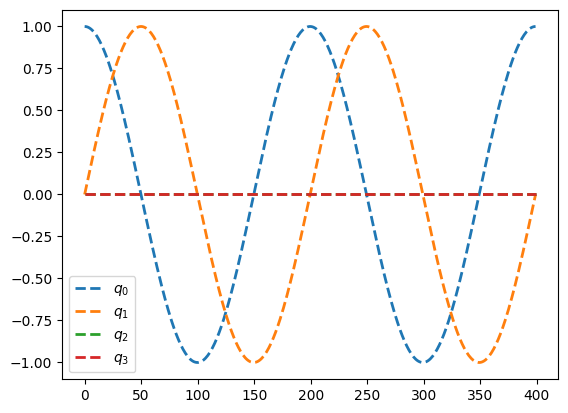

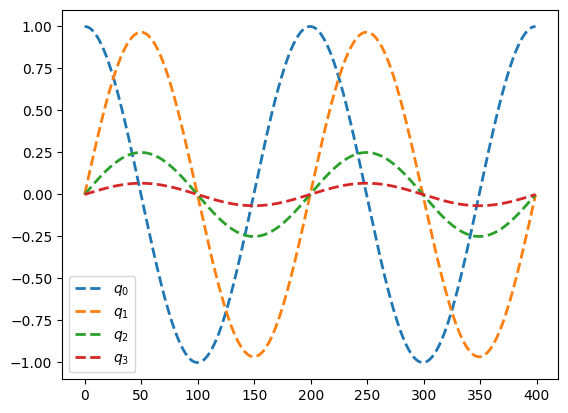

In [13]:
Q_accum_fix = R.generate_sinusoidal_quaternion(omega=2*np.pi, phi=0, psi=0, duration=2, samples=SAMPLES)
Q_accum_tilt = R.generate_sinusoidal_quaternion(omega=2*np.pi, phi=np.pi/12, psi=np.pi/12, duration=2, samples=SAMPLES)

Q_accum_fix = torch.tensor(Q_accum_fix)
plt.plot(Q_accum_fix[:, 0], '--', label=r'$q_0$', linewidth=2)
plt.plot(Q_accum_fix[:, 1], '--', label=r'$q_1$', linewidth=2)
plt.plot(Q_accum_fix[:, 2], '--', label=r'$q_2$', linewidth=2)
plt.plot(Q_accum_fix[:, 3], '--', label=r'$q_3$', linewidth=2)
plt.legend()
plt.show()

Q_accum_tilt = torch.tensor(Q_accum_tilt)
plt.plot(Q_accum_tilt[:, 0], '--', label=r'$q_0$', linewidth=2)
plt.plot(Q_accum_tilt[:, 1], '--', label=r'$q_1$', linewidth=2)
plt.plot(Q_accum_tilt[:, 2], '--', label=r'$q_2$', linewidth=2)
plt.plot(Q_accum_tilt[:, 3], '--', label=r'$q_3$', linewidth=2)
plt.legend()
plt.show()

In [15]:
forward_model = F.ForwardModelSimple(volume.shape[1])

FIX AXIS - NORMAL PROJECTION

In [16]:
projections_fix_sum = np.zeros((SAMPLES, 1, volume.shape[1], volume.shape[2]))

for i in range(SAMPLES):
    print(f"Simulating projection {i+1}/{SAMPLES}")
    volume_new = forward_model.apply_rotation(
        volume = torch.tensor(volume, dtype=torch.float32).to('cuda'), 
        q = torch.tensor(Q_accum_fix[i], dtype=torch.float32).to('cuda')
        )
    projections_fix_sum[i,0] = volume_new.sum(axis=2).cpu().numpy()   

Simulating projection 1/400
Simulating projection 2/400
Simulating projection 3/400
Simulating projection 4/400
Simulating projection 5/400
Simulating projection 6/400
Simulating projection 7/400
Simulating projection 8/400
Simulating projection 9/400
Simulating projection 10/400
Simulating projection 11/400
Simulating projection 12/400
Simulating projection 13/400
Simulating projection 14/400
Simulating projection 15/400
Simulating projection 16/400
Simulating projection 17/400
Simulating projection 18/400
Simulating projection 19/400
Simulating projection 20/400
Simulating projection 21/400
Simulating projection 22/400
Simulating projection 23/400
Simulating projection 24/400
Simulating projection 25/400
Simulating projection 26/400
Simulating projection 27/400
Simulating projection 28/400
Simulating projection 29/400
Simulating projection 30/400
Simulating projection 31/400
Simulating projection 32/400
Simulating projection 33/400


C:\Users\fredr\AppData\Local\Temp\ipykernel_7160\643767978.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(Q_accum_fix[i], dtype=torch.float32).to('cuda')


Simulating projection 34/400
Simulating projection 35/400
Simulating projection 36/400
Simulating projection 37/400
Simulating projection 38/400
Simulating projection 39/400
Simulating projection 40/400
Simulating projection 41/400
Simulating projection 42/400
Simulating projection 43/400
Simulating projection 44/400
Simulating projection 45/400
Simulating projection 46/400
Simulating projection 47/400
Simulating projection 48/400
Simulating projection 49/400
Simulating projection 50/400
Simulating projection 51/400
Simulating projection 52/400
Simulating projection 53/400
Simulating projection 54/400
Simulating projection 55/400
Simulating projection 56/400
Simulating projection 57/400
Simulating projection 58/400
Simulating projection 59/400
Simulating projection 60/400
Simulating projection 61/400
Simulating projection 62/400
Simulating projection 63/400
Simulating projection 64/400
Simulating projection 65/400
Simulating projection 66/400
Simulating projection 67/400
Simulating pro

TILTED AXIS - NORMAL PROJECTION

In [17]:
projections_tilt_sum = np.zeros((SAMPLES, 1, volume.shape[1], volume.shape[2]))

for i in range(SAMPLES):
    print(f"Simulating projection {i+1}/{SAMPLES}")
    volume_new = forward_model.apply_rotation(
        volume = torch.tensor(volume, dtype=torch.float32).to('cuda'), 
        q = torch.tensor(Q_accum_tilt[i], dtype=torch.float32).to('cuda')
        )
    projections_tilt_sum[i,0] = volume_new.sum(axis=2).cpu().numpy()   

Simulating projection 1/400
Simulating projection 2/400
Simulating projection 3/400
Simulating projection 4/400
Simulating projection 5/400
Simulating projection 6/400
Simulating projection 7/400
Simulating projection 8/400
Simulating projection 9/400
Simulating projection 10/400
Simulating projection 11/400
Simulating projection 12/400
Simulating projection 13/400
Simulating projection 14/400
Simulating projection 15/400
Simulating projection 16/400
Simulating projection 17/400
Simulating projection 18/400
Simulating projection 19/400
Simulating projection 20/400
Simulating projection 21/400
Simulating projection 22/400
Simulating projection 23/400
Simulating projection 24/400
Simulating projection 25/400
Simulating projection 26/400
Simulating projection 27/400
Simulating projection 28/400
Simulating projection 29/400
Simulating projection 30/400
Simulating projection 31/400
Simulating projection 32/400
Simulating projection 33/400
Simulating projection 34/400
Simulating projection 3

C:\Users\fredr\AppData\Local\Temp\ipykernel_7160\1077620545.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(Q_accum_tilt[i], dtype=torch.float32).to('cuda')


Simulating projection 74/400
Simulating projection 75/400
Simulating projection 76/400
Simulating projection 77/400
Simulating projection 78/400
Simulating projection 79/400
Simulating projection 80/400
Simulating projection 81/400
Simulating projection 82/400
Simulating projection 83/400
Simulating projection 84/400
Simulating projection 85/400
Simulating projection 86/400
Simulating projection 87/400
Simulating projection 88/400
Simulating projection 89/400
Simulating projection 90/400
Simulating projection 91/400
Simulating projection 92/400
Simulating projection 93/400
Simulating projection 94/400
Simulating projection 95/400
Simulating projection 96/400
Simulating projection 97/400
Simulating projection 98/400
Simulating projection 99/400
Simulating projection 100/400
Simulating projection 101/400
Simulating projection 102/400
Simulating projection 103/400
Simulating projection 104/400
Simulating projection 105/400
Simulating projection 106/400
Simulating projection 107/400
Simula

FIX AXIS - BRIGHTFIELD

In [18]:
projections_fix_brightfield = np.zeros((SAMPLES, 2, volume.shape[1], volume.shape[2]))
for i in range(SAMPLES):
    print(f"Simulating projection {i+1}/{SAMPLES}")
    volume_new = forward_model.apply_rotation(
        volume = torch.tensor(volume, dtype=torch.float32).to('cuda'), 
        q = torch.tensor(Q_accum_fix[i], dtype=torch.float32).to('cuda')
        )
    image = imaging_model_torch(torch.tensor(volume_new).to('cuda'))
    projections_fix_brightfield[i,0] = image.real.cpu().numpy().squeeze()
    projections_fix_brightfield[i,1] = image.imag.cpu().numpy().squeeze()


Simulating projection 1/400


C:\Users\fredr\AppData\Local\Temp\ipykernel_7160\69796714.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(Q_accum_fix[i], dtype=torch.float32).to('cuda')
C:\Users\fredr\AppData\Local\Temp\ipykernel_7160\69796714.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = imaging_model_torch(torch.tensor(volume_new).to('cuda'))


Simulating projection 2/400
Simulating projection 3/400
Simulating projection 4/400
Simulating projection 5/400
Simulating projection 6/400
Simulating projection 7/400
Simulating projection 8/400
Simulating projection 9/400
Simulating projection 10/400
Simulating projection 11/400
Simulating projection 12/400
Simulating projection 13/400
Simulating projection 14/400
Simulating projection 15/400
Simulating projection 16/400
Simulating projection 17/400
Simulating projection 18/400
Simulating projection 19/400
Simulating projection 20/400
Simulating projection 21/400
Simulating projection 22/400
Simulating projection 23/400
Simulating projection 24/400
Simulating projection 25/400
Simulating projection 26/400
Simulating projection 27/400
Simulating projection 28/400
Simulating projection 29/400
Simulating projection 30/400
Simulating projection 31/400
Simulating projection 32/400
Simulating projection 33/400
Simulating projection 34/400
Simulating projection 35/400
Simulating projection 

TILT AXIS - BRIGHTFIELD

In [19]:
projections_tilt_brightfield = np.zeros((SAMPLES, 2, volume.shape[1], volume.shape[2]))
for i in range(SAMPLES):
    print(f"Simulating projection {i+1}/{SAMPLES}")
    volume_new = forward_model.apply_rotation(
        volume = torch.tensor(volume, dtype=torch.float32).to('cuda'), 
        q = torch.tensor(Q_accum_tilt[i], dtype=torch.float32).to('cuda')
        )
    image = imaging_model_torch(torch.tensor(volume_new).to('cuda'))
    projections_tilt_brightfield[i,0] = image.real.cpu().numpy().squeeze()
    projections_tilt_brightfield[i,1] = image.imag.cpu().numpy().squeeze()

Simulating projection 1/400
Simulating projection 2/400
Simulating projection 3/400
Simulating projection 4/400


C:\Users\fredr\AppData\Local\Temp\ipykernel_7160\2297680846.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(Q_accum_tilt[i], dtype=torch.float32).to('cuda')
C:\Users\fredr\AppData\Local\Temp\ipykernel_7160\2297680846.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = imaging_model_torch(torch.tensor(volume_new).to('cuda'))


Simulating projection 5/400
Simulating projection 6/400
Simulating projection 7/400
Simulating projection 8/400
Simulating projection 9/400
Simulating projection 10/400
Simulating projection 11/400
Simulating projection 12/400
Simulating projection 13/400
Simulating projection 14/400
Simulating projection 15/400
Simulating projection 16/400
Simulating projection 17/400
Simulating projection 18/400
Simulating projection 19/400
Simulating projection 20/400
Simulating projection 21/400
Simulating projection 22/400
Simulating projection 23/400
Simulating projection 24/400
Simulating projection 25/400
Simulating projection 26/400
Simulating projection 27/400
Simulating projection 28/400
Simulating projection 29/400
Simulating projection 30/400
Simulating projection 31/400
Simulating projection 32/400
Simulating projection 33/400
Simulating projection 34/400
Simulating projection 35/400
Simulating projection 36/400
Simulating projection 37/400
Simulating projection 38/400
Simulating projecti

In [20]:
# Save all the data to 4 npz files with projections, volume and quaternions and that shall be the keys
np.savez("projections_fix_sum.npz", projections=projections_fix_sum, volume=volume, quaternions=Q_accum_fix)
np.savez("projections_tilt_sum.npz", projections=projections_tilt_sum, volume=volume, quaternions=Q_accum_tilt)
np.savez("projections_fix_brightfield.npz", projections=projections_fix_brightfield, volume=volume, quaternions=Q_accum_fix)
np.savez("projections_tilt_brightfield.npz", projections=projections_tilt_brightfield, volume=volume, quaternions=Q_accum_tilt)